<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


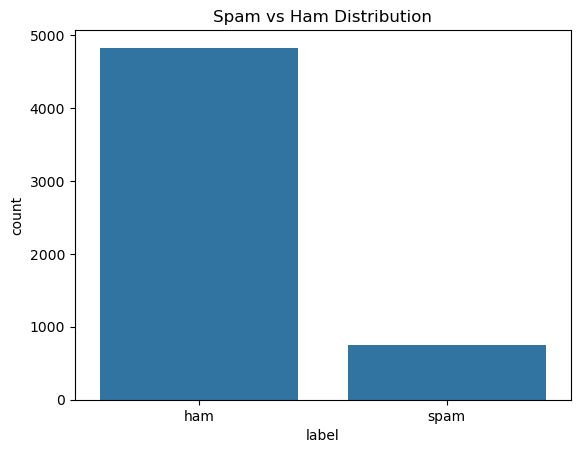

SPAM Examples:
2    Free entry in 2 a wkly comp to win FA Cup fina...
5    FreeMsg Hey there darling it's been 3 week's n...
8    WINNER!! As a valued network customer you have...
Name: message, dtype: object

HAM Examples:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
Name: message, dtype: object


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('spam.csv', encoding='latin-1')

# Look at the data
df.head()
df.info()
df.shape

# Check columns (might have extra unnamed columns)
df = df[['v1', 'v2']]  # Keep only first 2 columns
df.columns = ['label', 'message']  # Rename

# Check balance
df['label'].value_counts()
# Plot it
sns.countplot(x='label', data=df)
plt.title('Spam vs Ham Distribution')
plt.show()

# Look at some examples
print("SPAM Examples:")
print(df[df['label']=='spam']['message'].head(3))
print("\nHAM Examples:")
print(df[df['label']=='ham']['message'].head(3))

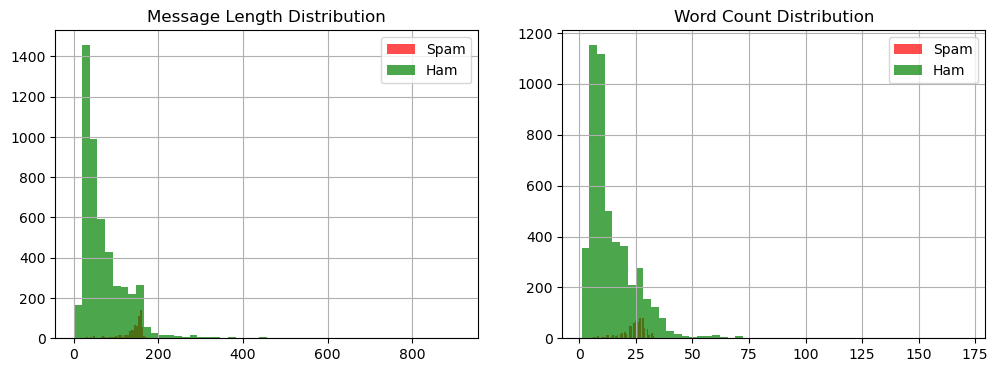

In [2]:
# Add length features
df['length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

# Compare spam vs ham
df.groupby('label')[['length', 'word_count']].mean()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df[df['label']=='spam']['length'].hist(ax=axes[0], bins=50, color='red', alpha=0.7)
df[df['label']=='ham']['length'].hist(ax=axes[0], bins=50, color='green', alpha=0.7)
axes[0].set_title('Message Length Distribution')
axes[0].legend(['Spam', 'Ham'])

df[df['label']=='spam']['word_count'].hist(ax=axes[1], bins=50, color='red', alpha=0.7)
df[df['label']=='ham']['word_count'].hist(ax=axes[1], bins=50, color='green', alpha=0.7)
axes[1].set_title('Word Count Distribution')
axes[1].legend(['Spam', 'Ham'])
plt.show()

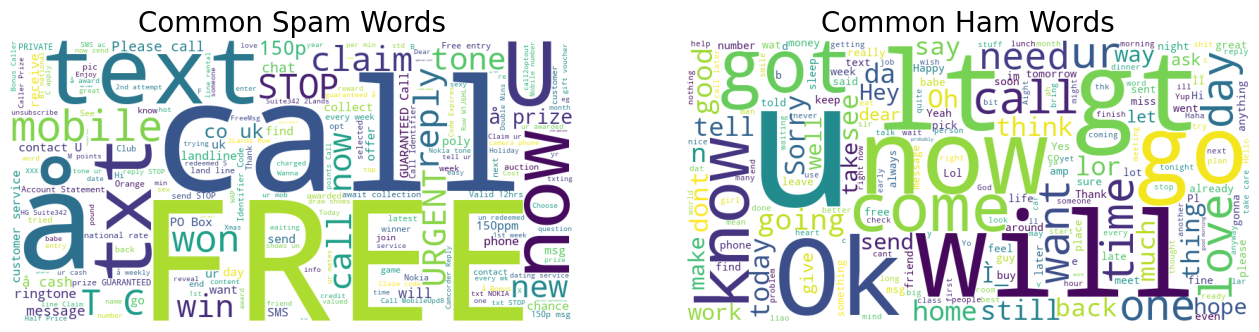

In [3]:
from wordcloud import WordCloud

# Spam words
spam_text = ' '.join(df[df['label']=='spam']['message'])
ham_text = ' '.join(df[df['label']=='ham']['message'])

# Word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

wc_spam = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
axes[0].imshow(wc_spam)
axes[0].set_title('Common Spam Words', size=20)
axes[0].axis('off')

wc_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
axes[1].imshow(wc_ham)
axes[1].set_title('Common Ham Words', size=20)
axes[1].axis('off')

plt.show()

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove phone numbers
    text = re.sub(r'\d{10}|\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', '', text)
    
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Tokenize and stem
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

# Apply preprocessing
df['clean_message'] = df['message'].apply(preprocess_text)

# Check results
print("Original:", df['message'][0])
print("Cleaned:", df['clean_message'][0])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned: go jurong point crazi avail bugi n great world la e buffet cine got amor wat


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=3000)

# Transform text to numbers
X = tfidf.fit_transform(df['clean_message']).toarray()
y = df['label'].map({'ham': 0, 'spam': 1})  # Convert to numbers

print(f"Shape: {X.shape}")
print(f"Spam count: {y.sum()}, Ham count: {len(y) - y.sum()}")

Shape: (5572, 3000)
Spam count: 747, Ham count: 4825


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 4457
Test samples: 1115



Training Naive Bayes...
Accuracy: 0.9722
Precision: 0.9917
Recall: 0.7987
F1-Score: 0.8848

Training Random Forest...
Accuracy: 0.9776
Precision: 1.0000
Recall: 0.8322
F1-Score: 0.9084

Training Logistic Regression...
Accuracy: 0.9659
Precision: 0.9912
Recall: 0.7517
F1-Score: 0.8550

Training SVM...
Accuracy: 0.9848
Precision: 1.0000
Recall: 0.8859
F1-Score: 0.9395

=== MODEL COMPARISON ===
                     Accuracy  Precision    Recall  F1-Score
Naive Bayes          0.972197   0.991667  0.798658  0.884758
Random Forest        0.977578   1.000000  0.832215  0.908425
Logistic Regression  0.965919   0.991150  0.751678  0.854962
SVM                  0.984753   1.000000  0.885906  0.939502


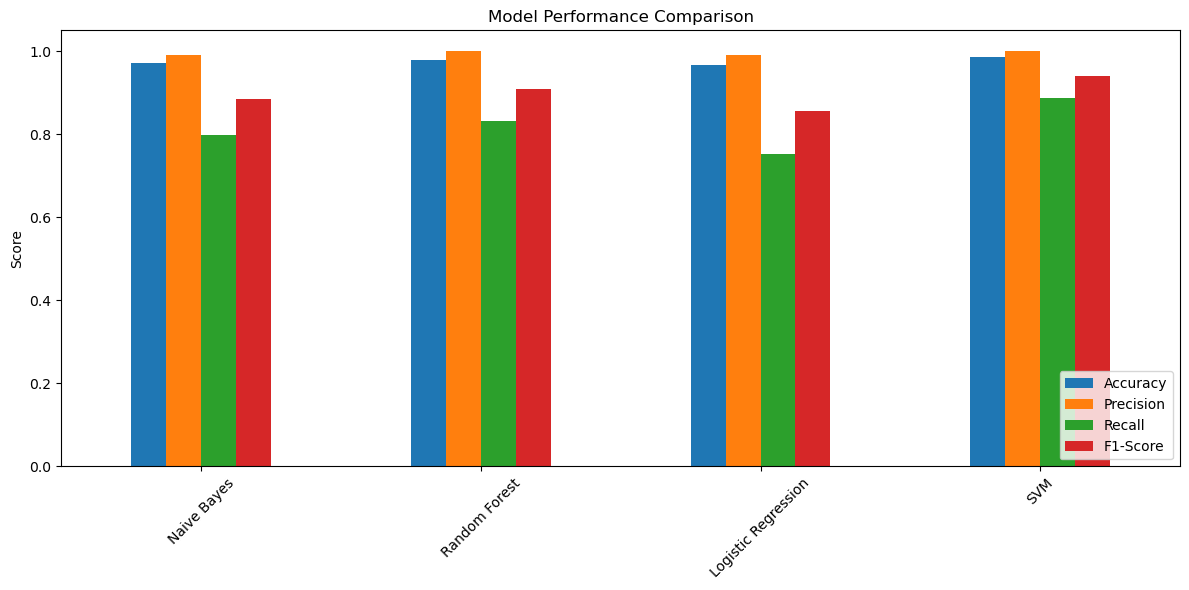

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Train multiple models
models = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    
    print(f"Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"Precision: {results[name]['Precision']:.4f}")
    print(f"Recall: {results[name]['Recall']:.4f}")
    print(f"F1-Score: {results[name]['F1-Score']:.4f}")

# Compare models
results_df = pd.DataFrame(results).T
print("\n=== MODEL COMPARISON ===")
print(results_df)

# Plot comparison
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Model retrained with probability support!
Accuracy: 0.9848


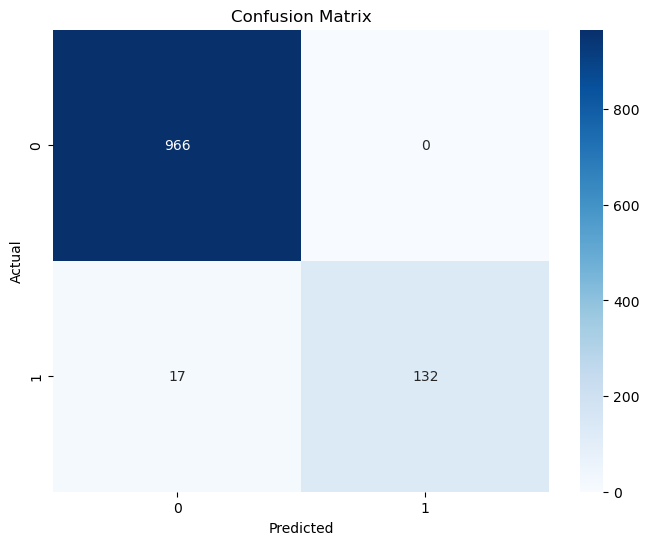

True Negatives (Ham correctly classified): 966
False Positives (Ham wrongly as Spam): 0
False Negatives (Spam wrongly as Ham): 17
True Positives (Spam correctly classified): 132


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Choose best model - SVM performed best!
# Train with probability=True
best_model = SVC(kernel='linear', random_state=42, probability=True)
best_model.fit(X_train, y_train)

# Test it
y_pred = best_model.predict(X_test)

print(f"Model retrained with probability support!")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate metrics manually
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Ham correctly classified): {tn}")
print(f"False Positives (Ham wrongly as Spam): {fp}")
print(f"False Negatives (Spam wrongly as Ham): {fn}")
print(f"True Positives (Spam correctly classified): {tp}")

In [9]:
import joblib

# Re-save the model with probability support
joblib.dump(best_model, 'spam_classifier_model')
joblib.dump(tfidf, 'tfidf_vectorizer')

print("✅ Model RE-SAVED with probability support!")

✅ Model RE-SAVED with probability support!


In [18]:
# Test probability
test_probs = best_model.predict_proba(X_test[:1])
print("Probabilities work:", test_probs)

Probabilities work: [[9.99523471e-01 4.76528879e-04]]
